# Datajoint pipeline for lab analysis

[2023-04-20 23:12:49,265][INFO]: Connecting root@127.0.0.1:3306
[2023-04-20 23:12:49,328][INFO]: Connected root@127.0.0.1:3306


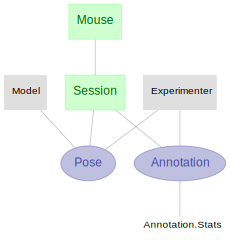

In [1]:
import datajoint as dj
from tables import schema, Mouse, Session, Experimenter, Annotation, Pose, Model

dj.Diagram(schema)

## Autopopulating the tables based on previous file structure
1. Find all label and pose files (with known naming convention)
2. extract all unique mice and sessions
3. convert to appropriate format (int, datetime)
4. Insert into tables (Mouse, Session)
5. Populate import tables (Pose, Annotation)

In [2]:
# add data to the database
import os
import glob
import datetime

dir_path = "D:\COLLABDATA\Seizures\seizure_examples\package"

label_files = glob.glob(os.path.join(dir_path, "*.csv"))
pose_files = glob.glob(os.path.join(dir_path, "*.h5"))

#naming convention is : T332-27072022-204839 Mouse-SessionDate-Time
#WARNING: specific for the naming convention for the session
base_name_files = [os.path.basename(x).split("_")[0] for x in label_files]

for num, f in enumerate(base_name_files):
    mouse, session_date = f.split("-")[0], ("-").join(f.split("-")[1:])
    #remove the T
    mouse = mouse[1:]
    #add to Mouse table
    Mouse.insert1((mouse, "1900-01-01", "M" , "C57BL6"), skip_duplicates = True)
    #add to Session table
    #transform the date into a datetime object
    session_date = datetime.datetime.strptime(session_date, "%d%m%Y-%H%M%S")
    #convert to table standard datetime format
    session_date = session_date.strftime("%Y-%m-%d-%H:%M:%S")
    #convert back to string
    session_date = str(session_date)
    Session.insert1((mouse, num, session_date, 0, "NaN", 30, pose_files[num], 0, label_files[num], "BORIS"),                 skip_duplicates = True)


#populate the Import tables
Annotation.populate()
Pose.populate()


In [3]:
#have a look at the main tables (joined)
Mouse * Session

mouse_id Unique animal ID,session_id id of experiment,dob date of birth,sex sex,genotype genotype of animal #TODO: should be restricted to Lookup table,session_time time of experiment #todo: change to datetime,"experimenter_id id of experimenter, linking to experimenter table",video_path path to video file,video_fps fps of recorded video file,pose_path path to pose file,pose_model_id unique id linking pose file to model,annotation_path path to annotation file,annotation_origin origin of annotation files (e.g. BORIS)
332,0,1900-01-01,M,C57BL6,2022-07-27 20:48:39,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839_No focal subject.csv,BORIS
332,1,1900-01-01,M,C57BL6,2022-07-27 21:18:41,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-211841.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-211841_No focal subject.csv,BORIS
332,2,1900-01-01,M,C57BL6,2022-07-27 21:48:43,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-214843.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-214843_No focal subject.csv,BORIS
332,3,1900-01-01,M,C57BL6,2022-07-27 22:18:45,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-221845.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-221845_No focal subject.csv,BORIS
333,4,1900-01-01,M,C57BL6,2022-07-27 21:48:43,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T333-27072022-214843.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T333-27072022-214843_No focal subject.csv,BORIS
333,5,1900-01-01,M,C57BL6,2022-07-27 22:48:48,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T333-27072022-224848.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T333-27072022-224848_No focal subject.csv,BORIS


## Testing some database fetching

Recover the pose estimation data from that session and convert it back into a pd.Dataframe
1. Get the pose estimation data from the database (fetch1)
2. Convert the data into a pd.DataFrame
3. Use additional information from the database to add the model name and the keypoints to the pd.DataFrame
4. Display the pd.DataFrame

In [5]:
import pandas as pd

mouse_id = 332
session_id = 0
experimenter_id = 0

pose_arr, keypoints = (Pose & f"mouse_id = {mouse_id}" & f"session_id = {session_id}").fetch1("pose", "keypoints")
#convert keypoints back to list
keypoints = keypoints.split(", ")

model_id = (Session & f"experimenter_id = {experimenter_id}" & f"session_id = {session_id}").fetch1("pose_model_id")

model_name = (Model & f'model_id = {model_id}').fetch1("name")

df = pd.DataFrame(pose_arr)
df.columns =pd.MultiIndex.from_product([[model_name], keypoints, ["x", "y", "likelihood"]]
                                       , names = ["model", "keypoints", "coords"]
                                       )
df



model     TestModelName                                                 \
keypoints      ear_left                          ear_right               
coords                x           y likelihood           x           y   
0            768.060303  303.915894        1.0  680.155823  316.045258   
1            771.877014  303.880249        1.0  680.094482  316.013702   
2            771.963501  303.849487        1.0  680.089600  316.009766   
3            771.918884  311.881409        1.0  679.972961  324.072968   
4            772.111572  312.031097        1.0  680.257629  332.042816   
...                 ...         ...        ...         ...         ...   
67974        467.992462  455.969635        1.0  540.142639  508.061432   
67975        467.996948  455.955078        1.0  540.133118  508.061707   
67976        468.017242  455.984650        1.0  540.130676  508.066193   
67977        468.003479  455.954437        1.0  540.130127  508.057343   
67978        467.998840  455.959808        1.0  540.118774  508.061920   

model                                                                ...  \
keypoints               hip_left                          hip_right  ...   
coords    likelihood           x           y likelihood           x  ...   
0                1.0  731.987000  187.944641        1.0  651.943848  ...   
1                1.0  727.726501  187.869583        1.0  651.749695  ...   
2                1.0  727.723083  187.945724        1.0  755.755798  ...   
3                1.0  772.284790  216.150909        1.0  652.183411  ...   
4                1.0  772.113708  220.072205        1.0  655.957764  ...   
...              ...         ...         ...        ...         ...  ...   
67974            1.0  404.054657  544.025330        1.0  500.132202  ...   
67975            1.0  404.045929  544.053162        1.0  500.127045  ...   
67976            1.0  404.048492  544.046570        1.0  500.147461  ...   
67977            1.0  404.052124  544.034668        1.0  500.168732  ...   
67978            1.0  404.053284  544.008484        1.0  500.168945  ...   

model                                                                \
keypoints       neck        nose                          tail_base   
coords    likelihood           x           y likelihood           x   
0                1.0  743.828979  360.086975        1.0  679.949097   
1                1.0  743.941650  359.961365        1.0  676.098572   
2                1.0  747.831116  356.064423        1.0  679.961304   
3                1.0  752.175659  348.292480        1.0  679.933960   
4                1.0  760.119446  348.020355        1.0  679.947388   
...              ...         ...         ...        ...         ...   
67974            1.0  536.151672  424.166473        1.0  431.917908   
67975            1.0  536.143555  424.156769        1.0  431.914917   
67976            1.0  536.155273  424.158051        1.0  431.915771   
67977            1.0  536.156494  424.161377        1.0  431.914581   
67978            1.0  536.163025  424.167145        1.0  431.912323   

model                                                                
keypoints                           tail_tip                         
coords              y likelihood           x           y likelihood  
0          167.877228        1.0  671.543945  375.730286        0.0  
1          164.051056        1.0  671.543945  375.730286        0.0  
2          167.911652        1.0  671.543945  375.730286        0.0  
3          167.934067        1.0  671.543945  375.730286        0.0  
4          167.910538        1.0  671.543945  375.730286        0.0  
...               ...        ...         ...         ...        ...  
67974      631.880615        1.0  420.075562  868.138489        1.0  
67975      631.880371        1.0  420.080322  868.137451        1.0  
67976      631.881226        1.0  420.079742  868.143066        1.0  
67977      631.880798        1.0  420.077850  868.144592       

## Retrieving specific information from a Computed table (Annotation.Stats)

Get some descriptive statistics from the database by querrying a dj.Part of Annotation
Get the number of annotations per behavior per mouse per session

In [6]:
Annotation.Stats()

mouse_id Unique animal ID,session_id id of experiment,experimenter_id Unique experimenter ID,behavior_id unique behavior id,total_frames total number of frames per behavior,total_perc perc. compared to total length of session,total_time total time in seconds
332,0,0,Eat,1197,0.0176081,39.9
332,0,0,Freeze,11325,0.166593,377.5
332,0,0,Groom,7305,0.107458,243.5
332,0,0,Head Nodding,549,0.00807591,18.3
332,0,0,Investigate,40407,0.594395,1346.9
332,0,0,other,1101,0.0161959,36.7
332,0,0,Rearing,231,0.00339806,7.7
332,0,0,Rest,3021,0.0444395,100.7
332,0,0,Seizure,2844,0.0418358,94.8
332,1,0,Freeze,7791,0.114764,259.7


Get the number of annotations per behavior for a specific mouse by fetching the data as a pd.DataFrame

In [11]:
query = (Annotation.Stats & "mouse_id = 332")
frame = query.fetch(format="frame")
#sum up total labels per behavior across all sessions for one mouse
# Note that total_perc would be wrong (summed up), so we need to recalculate it
desc_df = frame.groupby(["behavior_id"]).sum()
desc_df["total_perc"] /= desc_df["total_perc"].sum()
desc_df

,total_frames,total_perc,total_time
behavior_id,,,
Eat,1197,0.004402,39.9
Freeze,35202,0.129707,1173.4
Groom,24999,0.092106,833.3
Head Nodding,549,0.002019,18.3
Investigate,122094,0.450009,4069.8
Jump,60,0.000221,2.0
Rearing,3339,0.012316,111.3
Rest,40800,0.150337,1360.0
Seizure,13926,0.051334,464.2


# ... To be continued